In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Load Data
print("Loading datasets...")
train_df = pd.read_csv('../data/train.csv')
rev_df = pd.read_csv('../data/revenue_distribution_by_sector.csv')

Loading datasets...


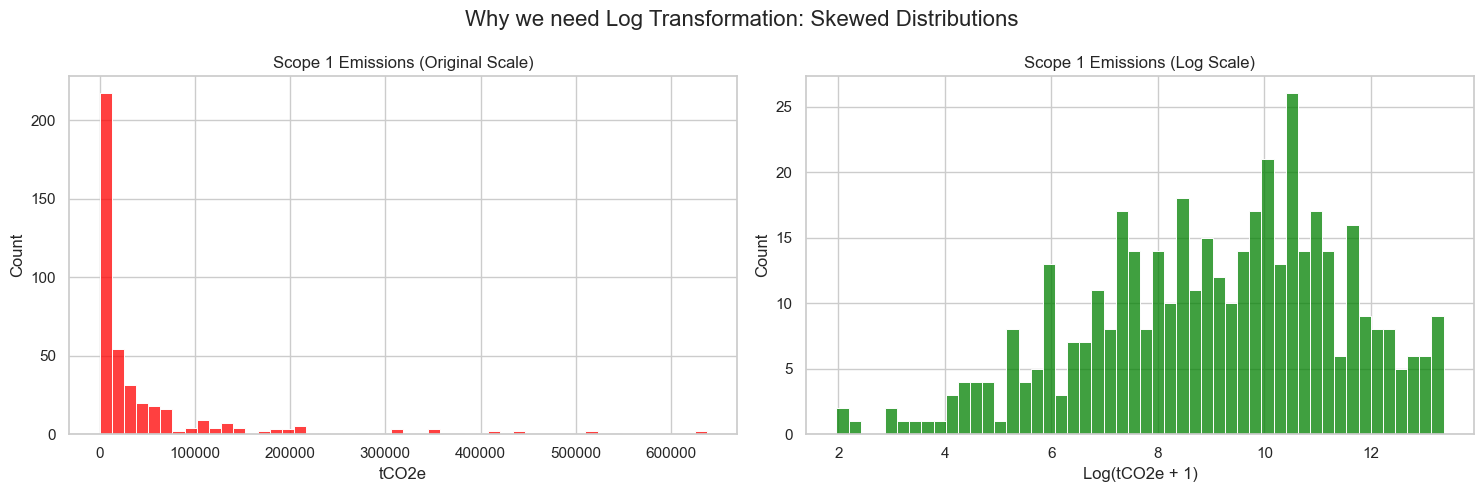

Scope 1 Skewness: 3.15 (High skew means outliers!)
Scope 2 Skewness: 7.34


In [2]:
# ==========================================
# 2. Target Variable Analysis (The "Pain Point")
# ==========================================
# Insight: Emissions are NOT normally distributed. They follow a Power Law.
# Most companies emit very little, a few emit HUGE amounts.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Original Scale (The "Messy" Reality)
sns.histplot(train_df['target_scope_1'], bins=50, ax=axes[0], color='red')
axes[0].set_title('Scope 1 Emissions (Original Scale)')
axes[0].set_xlabel('tCO2e')

# Plot Log Scale (The Solution)
# We add +1 to avoid log(0) errors, though emissions are likely non-zero
sns.histplot(np.log1p(train_df['target_scope_1']), bins=50, ax=axes[1], color='green')
axes[1].set_title('Scope 1 Emissions (Log Scale)')
axes[1].set_xlabel('Log(tCO2e + 1)')

plt.suptitle('Why we need Log Transformation: Skewed Distributions', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Scope 1 Skewness: {train_df['target_scope_1'].skew():.2f} (High skew means outliers!)")
print(f"Scope 2 Skewness: {train_df['target_scope_2'].skew():.2f}")

C:\Users\SamCodeMan\AppData\Local\Temp\ipykernel_9236\98541481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sector_stats.index, x=sector_stats.values, palette='viridis')


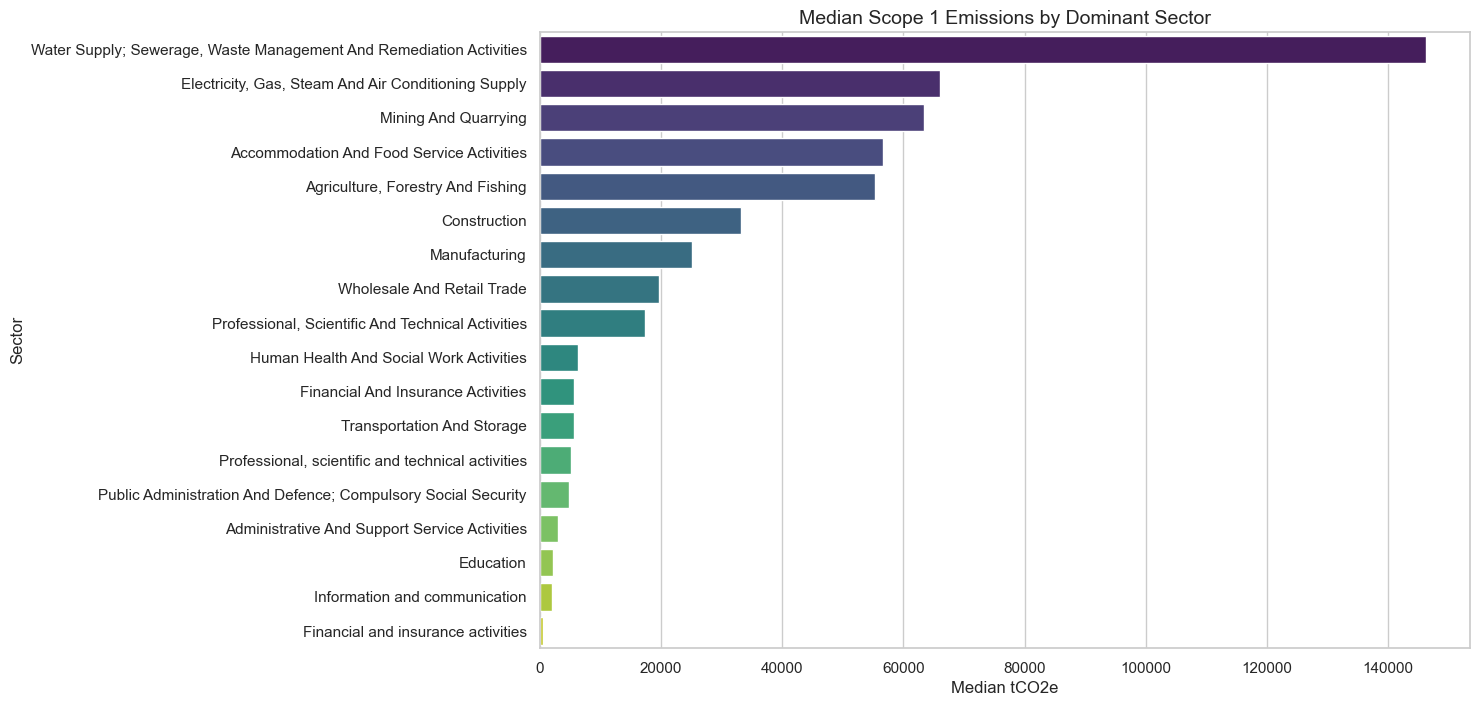

In [3]:
# ==========================================
# 3. Sector Analysis (The "Key Driver")
# ==========================================
# We need to find the "Dominant" sector for each company to visualize this easily
# (Since companies can be in multiple sectors, we pick the one with max revenue %)
idx = rev_df.groupby('entity_id')['revenue_pct'].idxmax()
dominant_sector = rev_df.loc[idx]
train_merged = train_df.merge(dominant_sector[['entity_id', 'nace_level_1_name']], on='entity_id', how='left')

# Calculate Median Scope 1 by Sector
sector_stats = train_merged.groupby('nace_level_1_name')['target_scope_1'].median().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(y=sector_stats.index, x=sector_stats.values, palette='viridis')
plt.title('Median Scope 1 Emissions by Dominant Sector', fontsize=14)
plt.xlabel('Median tCO2e')
plt.ylabel('Sector')
plt.show()

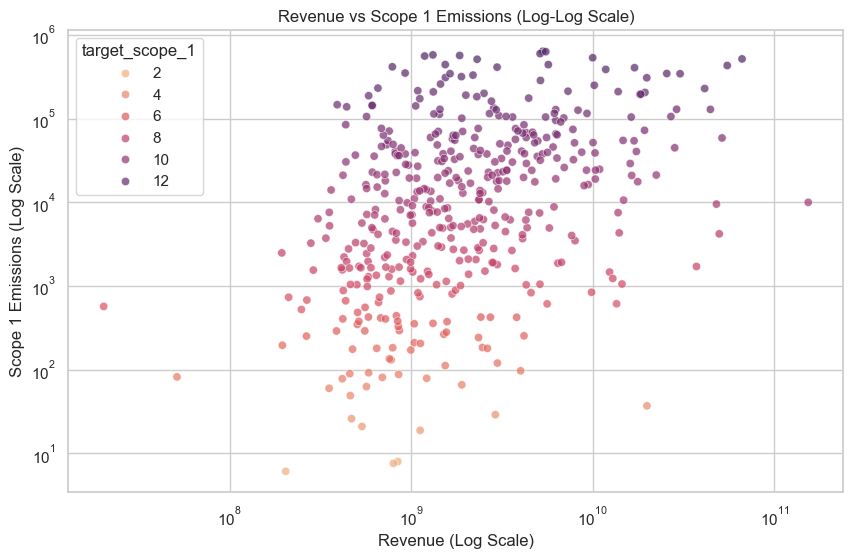

In [4]:
# ==========================================
# 4. Revenue vs Emissions (The "Scale" Hypothesis)
# ==========================================
# Does more money = more pollution?
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_df, 
    x='revenue', 
    y='target_scope_1', 
    hue=np.log1p(train_df['target_scope_1']), 
    palette='flare', 
    alpha=0.7
)
plt.xscale('log')
plt.yscale('log')
plt.title('Revenue vs Scope 1 Emissions (Log-Log Scale)')
plt.xlabel('Revenue (Log Scale)')
plt.ylabel('Scope 1 Emissions (Log Scale)')
plt.show()

C:\Users\SamCodeMan\AppData\Local\Temp\ipykernel_9236\2893651391.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='region_name', y=np.log1p(train_df['target_scope_1']), order=order, palette='coolwarm')


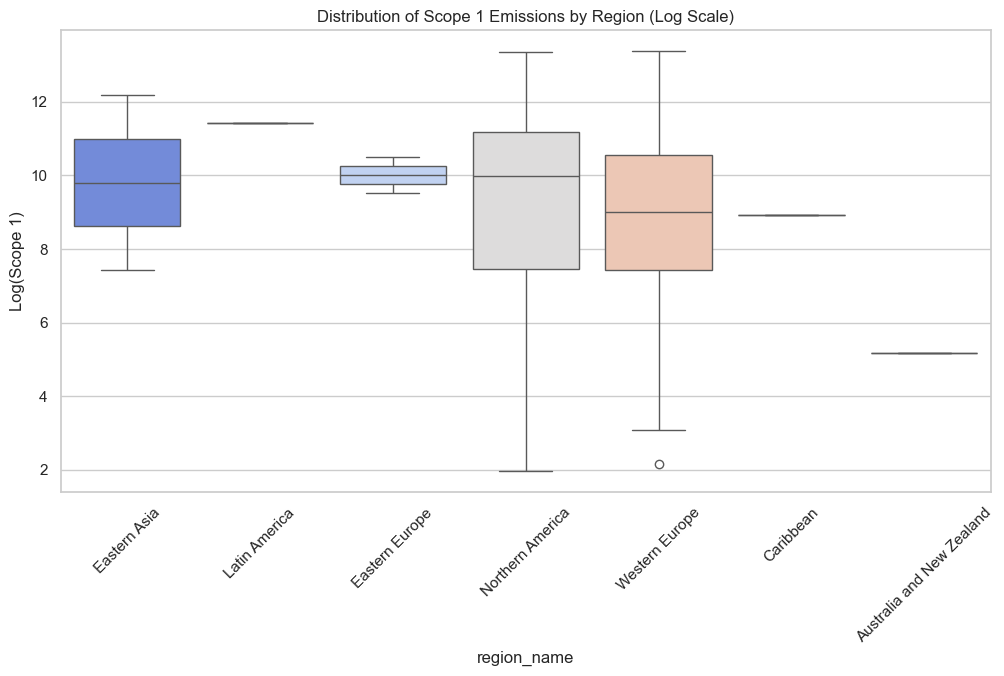

In [5]:
# ==========================================
# 5. Regional Differences
# ==========================================
# Do companies in different regions emit differently?
plt.figure(figsize=(12, 6))
order = train_df.groupby('region_name')['target_scope_1'].median().sort_values(ascending=False).index
sns.boxplot(data=train_df, x='region_name', y=np.log1p(train_df['target_scope_1']), order=order, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribution of Scope 1 Emissions by Region (Log Scale)')
plt.ylabel('Log(Scope 1)')
plt.show()

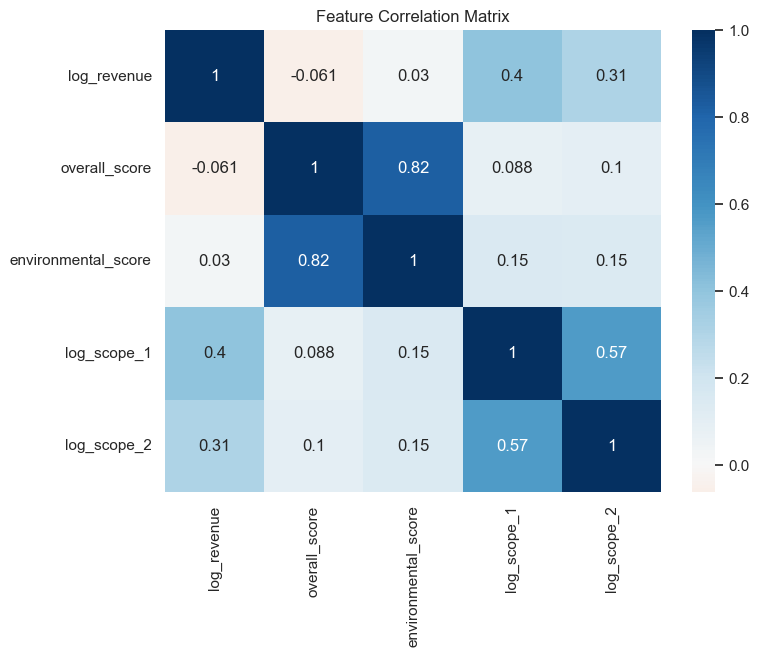

EDA Complete. Key Takeaways:
1. Target variables are highly right-skewed -> Use Log Transformation.
2. 'Water Supply' and 'Electricity' sectors are top median emitters.
3. Revenue has a moderate positive correlation (0.40) with Scope 1.


In [6]:
# ==========================================
# 6. Correlation Matrix
# ==========================================
# What actually correlates?
cols = ['revenue', 'overall_score', 'environmental_score', 'target_scope_1', 'target_scope_2']
# We use log versions for valid correlation
corr_df = train_df.copy()
corr_df['log_revenue'] = np.log1p(corr_df['revenue'])
corr_df['log_scope_1'] = np.log1p(corr_df['target_scope_1'])
corr_df['log_scope_2'] = np.log1p(corr_df['target_scope_2'])

corr_cols = ['log_revenue', 'overall_score', 'environmental_score', 'log_scope_1', 'log_scope_2']
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df[corr_cols].corr(), annot=True, cmap='RdBu', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

print("EDA Complete. Key Takeaways:")
print("1. Target variables are highly right-skewed -> Use Log Transformation.")
print("2. 'Water Supply' and 'Electricity' sectors are top median emitters.")
print("3. Revenue has a moderate positive correlation (0.40) with Scope 1.")